# Watermark Removal

## Setup and Imports

### Import Libraries

In [1]:
import os
import re
import random
from timeit import default_timer as timer
from glob import glob
from random import sample, seed

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageChops
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import transforms, models
from torchvision.models import vgg19
from pytorch_msssim import SSIM

## Helper Functions

### Convert PIL Image to Tensor

In [2]:
def PIL_to_tensor(path):
    """
    Convert a PIL image to a PyTorch tensor.
    
    Parameters:
    - path (str): Path to the image file.
    
    Returns:
    - image_tensor (Tensor): PyTorch tensor representation of the image.
    """
    image = Image.open(path).convert('L')
    to_tensor = transforms.ToTensor()
    image_tensor = to_tensor(image)
    return image_tensor

### Display Images

In [3]:
def display_images(original, watermarked, outputs, model, device):
    """
    Display original, watermarked, and output images side by side.
    
    Parameters:
    - original (Tensor): Original images.
    - watermarked (Tensor): Watermarked images.
    - outputs (Tensor): Model output images.
    - model (nn.Module): The model used for generating outputs.
    - device (torch.device): Device to run the model on (CPU or GPU).
    """
    plt.figure(figsize=(50, 30))
    plt.subplot(1, 3, 1)
    plt.imshow(original[0].cpu().numpy().transpose(1, 2, 0), cmap='gray')
    plt.title("Original")
    plt.subplot(1, 3, 2)
    plt.imshow(watermarked[0].cpu().numpy().transpose(1, 2, 0), cmap='gray')
    plt.title("Watermarked")
    plt.subplot(1, 3, 3)
    plt.imshow(outputs[0].cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')
    plt.title("Output")
    plt.show()

## Paths Setup

### Define Paths

In [4]:
paths = {
    'Image_Folder': 'Images',
    'Model_Folder': 'models',
    'Result_Folder': 'Results',
    'Data_Folder': 'data',
    'Data_SubFolder': 'Church_Music_Images_Downscaled',
    'SubFolder': "Watermark_Removal",
    'original_watermarked_path': 'data/Actual_Images/Low_Res_Watermark',
    'original_unwatermarked_path': 'data/Actual_Images/Low_Res_Shifted',
}
    
# Create directories if they do not exist
image_dir_path = os.path.join(paths['Image_Folder'], paths['SubFolder'])
os.makedirs(image_dir_path, exist_ok=True)

model_dir_path = os.path.join(paths['Model_Folder'], paths['SubFolder'])
os.makedirs(model_dir_path, exist_ok=True)

result_dir_path = os.path.join(paths['Result_Folder'], paths['SubFolder'])
os.makedirs(result_dir_path, exist_ok=True)

## Training Functions

### Training Step

In [5]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device,
               print_images=0):
    """
    Perform a single training step.
    
    Parameters:
    - model (nn.Module): The model to train.
    - dataloader (DataLoader): DataLoader for training data.
    - loss_fn (nn.Module): Loss function.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - device (torch.device): Device to run the training on (CPU or GPU).
    - print_images (int): Interval for displaying images during training (default: 0).
    
    Returns:
    - train_loss (float): Average training loss.
    """
    model.train()
    train_loss = 0
        
    for batch_idx, (original, watermarked) in tqdm(enumerate(dataloader), total=len(dataloader)):
        
        # Move data to the device
        original, watermarked = original.to(device), watermarked.to(device)
        
        # Forward pass
        outputs = model(watermarked)
        loss = loss_fn(outputs, original)
        
        # Zero grad, backward pass, optimizer step
        batch_loss = loss.item()
        train_loss += batch_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"\rBatch {batch_idx + 1}: Training Loss: {batch_loss:.6f}", end="")
        
        if batch_idx % print_images == 0:
            display_images(original, watermarked, outputs, model, device)

    train_loss /= len(dataloader)
    return train_loss

### Validation Step

In [6]:
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device,
             print_images=0):
    """
    Perform a single validation step.
    
    Parameters:
    - model (nn.Module): The model to validate.
    - dataloader (DataLoader): DataLoader for validation data.
    - loss_fn (nn.Module): Loss function.
    - device (torch.device): Device to run the validation on (CPU or GPU).
    - print_images (int): Interval for displaying images during validation (default: 0).
    
    Returns:
    - val_loss (float): Average validation loss.
    """
    model.eval()
    val_loss = 0
    
    with torch.inference_mode():
        for batch_idx, (original, watermarked) in tqdm(enumerate(dataloader), total=len(dataloader)):
            # Move data to the device
            original, watermarked = original.to(device), watermarked.to(device)
            
            # Forward pass
            outputs = model(watermarked)
            loss = loss_fn(outputs, original)
             
            batch_loss = loss.item()
            val_loss += batch_loss

            print(f"\rBatch {batch_idx + 1}: Validation Loss: {batch_loss:.6f}", end="")
    
            if batch_idx % print_images == 0:
                display_images(original, watermarked, outputs, model, device)
                
    val_loss /= len(dataloader)
    return val_loss

### Training Function

In [7]:
def train(model_name: str,
          model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          max_epochs: int = 3,
          save_epochs: int = 1,
          device=None,
          load_model: bool = True,
          save_model: bool = True,
          continue_training: bool = False,
          print_images: int = 0,
          model_dir_path=model_dir_path):
    """
    Train the model.
    
    Parameters:
    - model_name (str): Name of the model.
    - model (nn.Module): The model to train.
    - train_dataloader (DataLoader): DataLoader for training data.
    - val_dataloader (DataLoader): DataLoader for validation data.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - loss_fn (nn.Module): Loss function.
    - max_epochs (int): Maximum number of epochs to train (default: 3).
    - save_epochs (int): Interval for saving the model (default: 1).
    - device (torch.device): Device to run the training on (CPU or GPU).
    - load_model (bool): Flag to load an existing model (default: True).
    - save_model (bool): Flag to save the model (default: True).
    - continue_training (bool): Flag to continue training from the last checkpoint (default: False).
    - print_images (int): Interval for displaying images during training (default: 0).
    - model_dir_path (str): Path to the directory to save the model.
    
    Returns:
    - results (dict): Dictionary containing training and validation losses and training time.
    """
    # Define the full model path including the file name
    model_path = os.path.join(model_dir_path, f"{model_name}.pth")

    # Initialize a dictionary to store training and validation losses and accuracies for each epoch
    results = {"train_loss": [],
               "val_loss": []}

    # Load the existing model and losses if required
    if load_model:
        model_path, last_epoch = find_latest_checkpoint(model_dir_path, model_name)
        if model_path is None:
            print(f"No existing model found. Training a new model.")
            start_epoch = 1
        else:
            loaded = load_model_fn(model, model_path, results)
            if loaded and not continue_training:
                return results

            print(f"Continuing to train {model_name} from epoch {last_epoch} for {max_epochs - last_epoch} more epochs.")
            start_epoch = last_epoch + 1
    else:
        start_epoch = 1

    # Establish the start time for training
    start_time = timer()

    # Loop over epochs
    for epoch in tqdm(range(start_epoch, max_epochs + 1)):
        # Refresh the file list for training and validation datasets
        dataset.refresh_file_list(training=True)
        
        # Execute a training step and get training loss
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device,
                                print_images=print_images)
        
        # Refresh the file list for validation dataset
        dataset.refresh_file_list(training=False)
        
        # Execute a validation step and get validation loss
        val_loss = val_step(model=model,
                            dataloader=val_dataloader,
                            loss_fn=loss_fn,
                            device=device,
                            print_images=print_images)
        
        # Print losses for this epoch
        print(f"\n\nEpoch: {epoch} | Train loss: {train_loss:.6f} | Val loss: {val_loss:.6f}\n")

        # Append losses to results dictionary
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

        # Establish the end time for the current epoch and calculate training time
        end_time = timer()
        train_time = end_time - start_time
        results['train_time'] = train_time  # Add train_time to the results dictionary
      
        # Condition to save the model every save_epochs epochs
        if (epoch - 1) % save_epochs == 0 and save_model:
            epoch_model_path = os.path.join(model_dir_path, f"{model_name}_epoch_{epoch}.pth")
            results['last_epoch'] = epoch  # Store the current epoch number
            save_model_fn(model, epoch_model_path, results)
    
    return results

### Load Model Function

In [8]:
def load_model_fn(model, model_path, results):
    """
    Load the model from a checkpoint.
    
    Parameters:
    - model (nn.Module): The model to load the state into.
    - model_path (str): Path to the checkpoint file.
    - results (dict): Dictionary to store the loaded results.
    
    Returns:
    - loaded (bool): Flag indicating if the model was successfully loaded.
    """
    if os.path.isfile(model_path):
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['state_dict'], strict=False)
        results['train_loss'] = checkpoint['train_loss']
        results['val_loss'] = checkpoint['val_loss']
        results['train_time'] = checkpoint['train_time']
        results['last_epoch'] = checkpoint.get('last_epoch', 0)  # Load the last_epoch value if it exists
        print(f"Model loaded from {model_path}")
        return True
    else:
        print(f"No existing model found at {model_path}. Training a new model.")
        return False

### Save Model Function

In [9]:
def save_model_fn(model, model_path, results):
    """
    Save the model to a checkpoint.
    
    Parameters:
    - model (nn.Module): The model to save.
    - model_path (str): Path to save the checkpoint file.
    - results (dict): Dictionary containing the results to save.
    """
    save_dict = {
        'state_dict': model.state_dict(),
        'train_loss': results['train_loss'],
        'val_loss': results['val_loss'],
        'train_time': results['train_time'],
        'last_epoch': results.get('last_epoch', 0)  # Save the last_epoch value if it exists
    }
    torch.save(save_dict, model_path)
    print(f"Model saved at {model_path}")

### Find Latest Checkpoint

In [10]:
def find_latest_checkpoint(model_dir_path, model_name):
    """
    Find the latest checkpoint for a given model.
    
    Parameters:
    - model_dir_path (str): Directory path where the model checkpoints are stored.
    - model_name (str): Name of the model.
    
    Returns:
    - latest_model_path (str): Path to the latest model checkpoint.
    - max_epoch (int): The latest epoch number.
    """
    max_epoch = -1
    latest_model_path = None
    
    for filename in os.listdir(model_dir_path):
        if model_name in filename and filename.endswith(".pth"):
            epoch_number = int(filename.split('_epoch_')[-1].split('.pth')[0])
            if epoch_number > max_epoch:
                max_epoch = epoch_number
                latest_model_path = os.path.join(model_dir_path, filename)
    
    return latest_model_path, max_epoch

### Save Plot

In [11]:
def save_plot(file_name, dir_path, plt):
    """
    Save the plot to a specified directory.
    
    Parameters:
    - file_name (str): Name of the file to save the plot as.
    - dir_path (str): Directory path to save the plot.
    - plt (matplotlib.pyplot): The plot object to save.
    """
    # Construct the full path for the image
    full_path = os.path.join(dir_path, file_name)
    
    # Save the plot
    plt.savefig(full_path)
    
    # Print a message indicating the image has been saved
    print(f"Image has been saved at {full_path}")


### Plot Training and Validation Loss

In [12]:
def plot_train_val_loss(results, model, image_dir_path=image_dir_path):
    plt.figure(figsize=(10,5))

    plt.plot(results['train_loss'], label='Training Loss')
    plt.plot(results['val_loss'], label='Validation Loss')

    # Find the epoch with the lowest validation loss
    min_val_loss_epoch = results['val_loss'].index(min(results['val_loss']))
    min_val_loss_value = results['val_loss'][min_val_loss_epoch]

    # Get current y-axis and x-axis limits
    y_lim = plt.ylim()
    x_lim = plt.xlim()

    # Determine annotation position
    offset_y = 0.05 * (y_lim[1] - y_lim[0])  # 5% of y-axis range for vertical adjustment
    offset_x = 0.05 * (x_lim[1] - x_lim[0])  # 5% of x-axis range for horizontal adjustment
    
    if min_val_loss_epoch > (x_lim[1] - x_lim[0]) / 2:
        text_position_x = min_val_loss_epoch - offset_x
    else:
        text_position_x = min_val_loss_epoch + offset_x

    text_position_y = min_val_loss_value + offset_y

    # Annotate the point with the epoch and validation loss value
    plt.annotate(f'Lowest Val Loss\nEpoch: {min_val_loss_epoch + 1}\nLoss: {min_val_loss_value:.5f}',
                 xy=(min_val_loss_epoch, min_val_loss_value),
                 xytext=(text_position_x, text_position_y),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=9,
                 ha='center',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train and Validation Loss for {model}')
    plt.legend()

    save_plot(f"{model}_Train_Val_Loss", image_dir_path, plt)

    plt.show()

## Dataset

### Modified Original Watermark Dataset

In [13]:
class ModifiedOriginalWatermarkDataset(Dataset):
    def __init__(self, dir_unwatermarked, dir_watermarked, dir_unwatermarked_online, dir_watermarked_online, dir_unwatermarked_other, dir_watermarked_other, alpha=0.1, random_state=None):
        """
        Initialize the dataset with various directories and parameters.
        
        Parameters:
        - dir_unwatermarked (str): Directory path for unwatermarked images.
        - dir_watermarked (str): Directory path for watermarked images.
        - dir_unwatermarked_online (str): Directory path for unwatermarked online images.
        - dir_watermarked_online (str): Directory path for watermarked online images.
        - dir_unwatermarked_other (str): Directory path for other unwatermarked images.
        - dir_watermarked_other (str): Directory path for other watermarked images.
        - alpha (float): Fraction of data to use for validation (default: 0.1).
        - random_state (int): Seed for reproducibility (default: None).
        """
        self.dir_unwatermarked = dir_unwatermarked
        self.dir_watermarked = dir_watermarked
        self.dir_unwatermarked_online = dir_unwatermarked_online
        self.dir_watermarked_online = dir_watermarked_online
        self.dir_unwatermarked_other = dir_unwatermarked_other
        self.dir_watermarked_other = dir_watermarked_other

        random.seed(42)
        
        all_files = os.listdir(self.dir_unwatermarked)
        self.train_files, self.val_files = train_test_split(all_files, test_size=alpha, random_state=random_state)

        self.file_list = []
        self.refresh_file_list(training=True, print_counts=False)

        self.transform = transforms.Compose([
            transforms.Resize((792, 612)),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

    def refresh_file_list(self, training=True, print_counts=True):
        """
        Refresh the file list for training or validation.
        
        Parameters:
        - training (bool): Flag to indicate if the file list is for training (default: True).
        - print_counts (bool): Flag to print the counts of each file type (default: True).
        """
        if training:
            correlated_online_files = os.listdir(self.dir_unwatermarked_online)
            other_files = os.listdir(self.dir_unwatermarked_other)
            
            self.file_list = [(f, 'original') for f in self.train_files] + \
                             [(f, 'other') for f in random.sample(other_files, len(self.train_files) // 10)] + \
                             [(f, 'online') for f in random.sample(correlated_online_files, len(self.train_files) // 20)]
            
            random.shuffle(self.file_list)
            
            if print_counts:
                # Count the number of files for each type and display them
                counts = {'original': 0, 'online': 0, 'other': 0}
                for _, source in self.file_list:
                    counts[source] += 1
                print(f"\nNumber of original files: {counts['original']}")
                print(f"Number of other files: {counts['other']}")
                print(f"Number of online files: {counts['online']}")            
        else:
            self.file_list = [(f, 'original') for f in self.val_files]
            random.shuffle(self.file_list)  # Shuffle the validation files.
            if print_counts:
                # Count the number of files for each type and display them
                counts = {'original': 0, 'online': 0, 'other': 0}
                for _, source in self.file_list:
                    counts[source] += 1
                print(f"\n\nNumber of original files: {counts['original']}")
                print(f"Number of other files: {counts['other']}")
                print(f"Number of online files: {counts['online']}")

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        """
        Get an item from the dataset.
        
        Parameters:
        - idx (int): Index of the item.
        
        Returns:
        - unwatermarked_img_tensor (Tensor): Unwatermarked image tensor.
        - watermarked_img_tensor (Tensor): Watermarked image tensor.
        """
        file_name, source = self.file_list[idx]
        
        if source == 'original':
            unwatermarked_dir, watermarked_dir = self.dir_unwatermarked, self.dir_watermarked
        elif source == 'online':
            unwatermarked_dir, watermarked_dir = self.dir_unwatermarked_online, self.dir_watermarked_online
        else:  # 'other'
            unwatermarked_dir, watermarked_dir = self.dir_unwatermarked_other, self.dir_watermarked_other

        unwatermarked_img = Image.open(os.path.join(unwatermarked_dir, file_name))
        watermarked_img = Image.open(os.path.join(watermarked_dir, file_name))

        unwatermarked_img_tensor = self.transform(unwatermarked_img)
        watermarked_img_tensor = self.transform(watermarked_img)
        
        return unwatermarked_img_tensor, watermarked_img_tensor

### Create Dataset Instance

In [14]:
dataset = ModifiedOriginalWatermarkDataset(
    dir_unwatermarked=paths['original_unwatermarked_path'],
    dir_watermarked=paths['original_watermarked_path'],
    dir_unwatermarked_online='data/Actual_Images/Low_Res_Online',
    dir_watermarked_online='data/Actual_Images/Low_Res_Online',
    dir_unwatermarked_other='data/Church_Music_Extracted/Low_Res',
    dir_watermarked_other='data/Church_Music_Extracted/Low_Res',
    alpha=0.1,
    random_state=42  # Ensuring reproducibility
)

## Model Configuration

### Define Constants

In [15]:
# Constants
MAX_EPOCHS = 500
SAVE_EPOCHS = 1
BATCH_SIZE = 4
LEARNING_RATE = 0.001
LOAD_MODEL = True
SAVE_MODEL = True
CONTINUE_TRAINING = True
PRINT_IMAGES = 500

### Create DataLoaders

In [16]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)  # No shuffling for validation

### UNet Model

In [17]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(1, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)
        self.enc5 = self.conv_block(256, 512)

        # Middle
        self.middle = nn.Sequential(
            self.conv_block(512, 1024),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        )

        # Decoder
        self.dec5 = self.conv_block(512 + 512, 512)
        self.dec4 = self.conv_block(512 + 256, 256)
        self.dec3 = self.conv_block(256 + 128, 128)
        self.dec2 = self.conv_block(128 + 64, 64)
        self.dec1 = self.conv_block(64 + 32, 32)

        # Final Layer
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """
        Convolutional block with Conv2D, BatchNorm, and ReLU.
        
        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        
        Returns:
        - Sequential model containing the convolutional block.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        enc5 = self.enc5(F.max_pool2d(enc4, 2))
        
        # Middle
        middle = self.middle(F.max_pool2d(enc5, 2))
        enc5 = enc5[:, :, :middle.shape[2], :]
        middle = middle + enc5  # Skip connection

        # Decoder
        dec5 = self.dec5(torch.cat([F.interpolate(middle, size=enc5.shape[2:]), enc5], dim=1))
        dec4 = self.dec4(torch.cat([F.interpolate(dec5, size=enc4.shape[2:]), enc4], dim=1))
        dec3 = self.dec3(torch.cat([F.interpolate(dec4, size=enc3.shape[2:]), enc3], dim=1))
        dec2 = self.dec2(torch.cat([F.interpolate(dec3, size=enc2.shape[2:]), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, size=enc1.shape[2:]), enc1], dim=1))

        # Final Layer
        final_output = self.final_conv(dec1)
        
        return final_output.clamp(0, 1)


### Loss Functions

#### Perceptual Loss

In [18]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg19(pretrained=True).features
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x_vgg = self.vgg(x)
        y_vgg = self.vgg(y)
        loss = F.l1_loss(x_vgg, y_vgg)
        return loss

#### Combined Loss

In [19]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=0.5, gamma=0.5):
        super(CombinedLoss, self).__init__()
        self.ssim_module = SSIM(data_range=1.0, size_average=True, channel=1)
        self.l1_loss = nn.L1Loss()
        self.perceptual_loss = PerceptualLoss()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, outputs, original):
        ssim_loss = 1 - self.ssim_module(outputs, original)
        l1 = self.l1_loss(outputs, original)
        
        # Convert grayscale to 3-channel image for VGG19
        outputs_3ch = torch.cat([outputs] * 3, dim=1)
        original_3ch = torch.cat([original] * 3, dim=1)

        perceptual = self.perceptual_loss(outputs_3ch, original_3ch)

        loss = self.alpha * l1 + self.beta * perceptual + self.gamma * ssim_loss

        return loss

## Model Initialization

### Dual GPU Configuration

In [20]:
# Dual GPUS
device = torch.device("cuda:1")

model = nn.DataParallel(UNet(), device_ids=[1, 0]).to(device)
loss_fn = CombinedLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/home/sd205521/anaconda3/envs/rapids-23.12/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sd205521/anaconda3/envs/rapids-23.12/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Single GPU Configuration (Optional)

In [21]:
# # Single GPU
# device = torch.device("cuda:1")

# model = UNet().to(device)
# loss_fn = CombinedLoss().to(device)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training and Evaluation

### Train the Model

Model loaded from models/Watermark_Removal/model_epoch_500.pth
Image has been saved at Images/Watermark_Removal/model_Train_Val_Loss


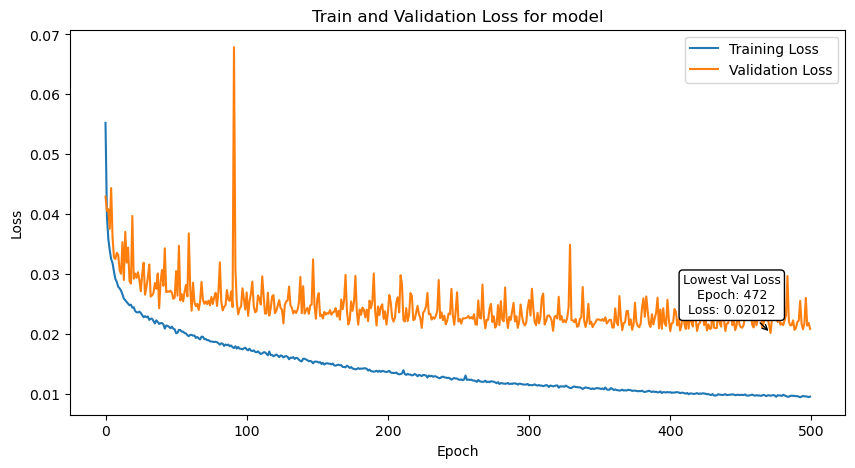

In [22]:
model_results = train(model_name='model',
                      model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      max_epochs=MAX_EPOCHS,
                      save_epochs=SAVE_EPOCHS,
                      device=device,
                      load_model=LOAD_MODEL,
                      save_model=False,
                      continue_training=False,
                      print_images=PRINT_IMAGES)

plot_train_val_loss(model_results, 'model', image_dir_path=image_dir_path)

### Continue Training the Model

In [23]:
model_results = train(model_name='model',
                      model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      max_epochs=MAX_EPOCHS,
                      save_epochs=SAVE_EPOCHS,
                      device=device,
                      load_model=LOAD_MODEL,
                      save_model=SAVE_MODEL,
                      continue_training=CONTINUE_TRAINING,
                      print_images=PRINT_IMAGES)


Model loaded from models/Watermark_Removal/model_epoch_500.pth
Continuing to train model from epoch 500 for 0 more epochs.


0it [00:00, ?it/s]

### Plot Training and Validation Loss

Image has been saved at Images/Watermark_Removal/model_Train_Val_Loss


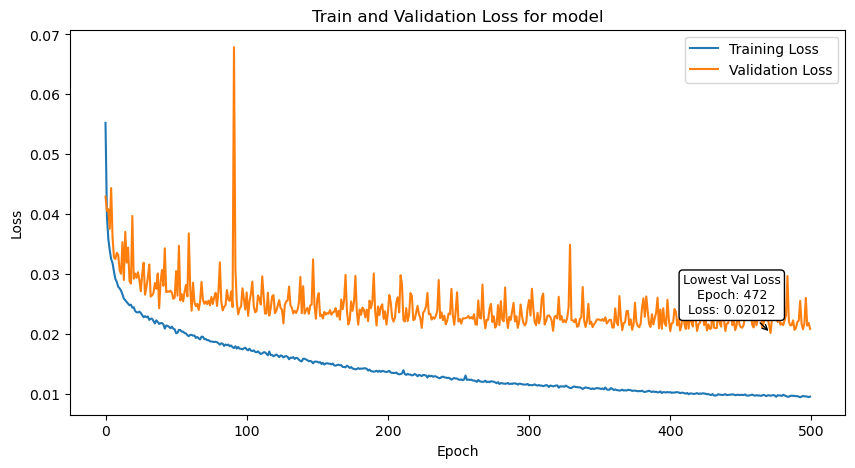

In [24]:
plot_train_val_loss(model_results, 'model', image_dir_path=image_dir_path)